The purpose of this notebook is to experiment with different numerical feature engineering techniques to improve the performance of the Naive Bayes model which only uses categorical features. To continue favouring DTSTCPW (doing the simpliest thing that could possibly work), we'll first address the `pdays` variable which had a large number of missing values. 

It is unlikely that the imputaton will have a huge impact since few customers have an associated `pdays` value (most are '999') but it is the easiest feature to engineer. Once we've some different approaches to imputation, we'll move onto exploring other numeric values.

In [5]:
%load_ext autoreload
%autoreload 2

from utils import code

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Support
from support.model import Model, build_tuned_model
from support.datasets import get_data
from support.experiments import experiment_3, get_auc_scorer, display_model_performance
from support import parameters as params

# sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

In [67]:
X_train, y_train = get_data('../data/train.csv')
X_test, y_test = get_data('../data/test.csv')
X_train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,25,blue-collar,single,high.school,no,yes,no,cellular,jul,mon,619,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1
1,40,admin.,married,high.school,no,no,no,telephone,jun,thu,97,1,999,0,nonexistent,1.4,94.465,-41.8,4.958,5228.1
2,51,technician,married,university.degree,no,yes,no,cellular,aug,wed,512,5,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1
3,37,blue-collar,married,high.school,unknown,yes,no,cellular,jul,tue,423,1,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1
4,54,housemaid,married,university.degree,unknown,yes,no,cellular,aug,thu,297,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1


In [68]:
print('Number of training instances:', len(X_train))
print('Number of test instances:', len(X_test))

Number of training instances: 32950
Number of test instances: 8238


Take a random sample to speed up CV

In [69]:
X_train_cv = X_train.sample(n=10000, random_state=1)
y_train_cv = y_train[X_train_cv.index]

### Establish baseline

In [17]:
scorer = get_auc_scorer()

In [72]:
# Load the model
tuned_model = Model.load('../models/experiment-1-model.pkl')
nb_model = Model(tuned_model.name, tuned_model.model, experiment_3.get_pipeline())

# Train it
nb_model.train(X_train, y_train)

# Score it
nb_model.score(X_test, y_test, scorer)

0.6590775213453465

### Deal with missing values in pdays variable

We previously ignored the pdays variable since most values were missing as indicated by a value of '999'. For these missing values, we'll try a few different strategies to assess the impact on the models:

* Use mean imputation
* Use median imputation
* Add an indicator for missing values and test with mean or median imputation (whichever method worked best)

What is the distribution of missing vs. not missing in the training and test sets?

In [73]:
pdays_train = (
  pd.concat([X_train[['pdays']], y_train], axis=1)
    .assign(is_missing=lambda x: x['pdays'] == 999)
)
pdays_train.head()

,pdays,y,is_missing
0,999,0,True
1,999,0,True
2,999,1,True
3,999,0,True
4,999,0,True


In [74]:
pdays_train.groupby('is_missing').size() / len(pdays_train)

is_missing
False    0.036844
True     0.963156
dtype: float64

In [75]:
pdays_test = (
  pd.concat([X_test[['pdays']], y_test], axis=1)
    .assign(is_missing=lambda x: x['pdays'] == 999)
)
pdays_test.head()

,pdays,y,is_missing
0,999,1,True
1,999,0,True
2,999,0,True
3,999,0,True
4,999,0,True


In [76]:
pdays_test.groupby('is_missing').size() / len(pdays_test)

is_missing
False    0.036538
True     0.963462
dtype: float64

Is the response rate significantly different from those customers who were previously contacted?

In [77]:
pdays_train.groupby(['is_missing', 'y']).size() / pdays_train.groupby(['is_missing']).size()

is_missing  y
False       0    0.367381
            1    0.632619
True        0    0.907235
            1    0.092765
dtype: float64

Customers who were previously contacted were significantly more likely to convert than those who were not. Let's see what kind of impact this has on our baseline model.

In [90]:
# Create the indicator
X_train_pdays = X_train.copy()
X_train_pdays['pdays'] = X_train_pdays['pdays'].apply(lambda x: 1 if x != 999 else 0)

X_test_pdays = X_test.copy()
X_test_pdays['pdays'] = X_test_pdays['pdays'].apply(lambda x: 1 if x != 999 else 0)

# Create pdays pipeline
pdays_ct = ColumnTransformer([('pdays', OneHotEncoder(), ['pdays'])])

# Create a feature union to add pdays
pipeline = experiment_3.get_pipeline()
pdays_pipeline = FeatureUnion([
  ('pipeline', pipeline), 
  ('pdays_pipeline', pdays_ct)])

# Reload the model and train it with the pdays variable
# Load the model
tuned_model = Model.load('../models/experiment-1-model.pkl')
nb_model = Model(tuned_model.name, tuned_model.model, pdays_pipeline)

# Train it
nb_model.train(X_train_pdays, y_train)

# Score it
nb_model.score(X_test_pdays, y_test, scorer)

/anaconda3/envs/py35-ds/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:363: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


0.6677452356243219

In [98]:
display_model_performance(nb_model, X_test_pdays, y_test)

Number of targeted customers: 543
Model profit: $322,722
Model lift over basline profit: 1.4 or $95,304
Targeted conversion rate: 0.56
Conversion rate lift over baseline: 1.41

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       241
         1.0       0.56      1.00      0.71       302

   micro avg       0.56      0.56      0.56       543
   macro avg       0.28      0.50      0.36       543
weighted avg       0.31      0.56      0.40       543



/anaconda3/envs/py35-ds/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/py35-ds/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/envs/py35-ds/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


By creating an indicator for `pdays`, AUC improves by ~1% (.08%) and precision improves by 1%, leading to an ~\$6.4K in additional profit.

### Explore other features

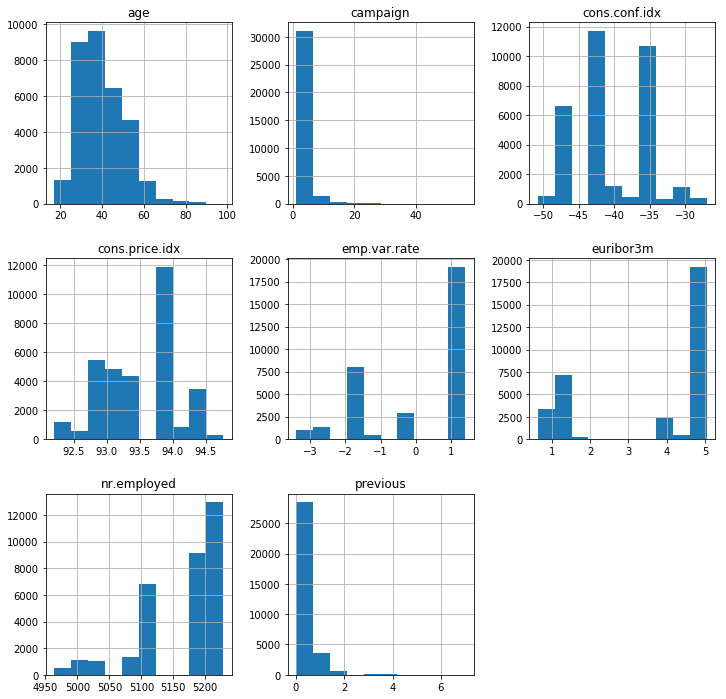

In [21]:
numeric_features = X_train[experiment_1.NUMERIC_FEATURES]
numeric_features.hist(figsize=(12,12));

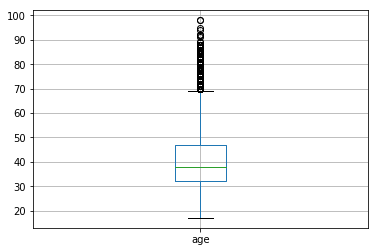

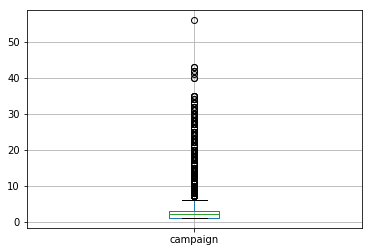

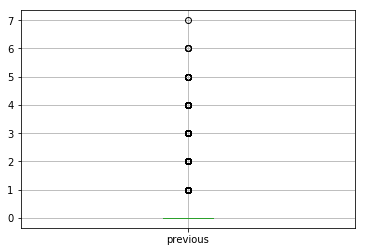

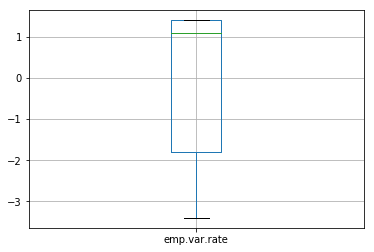

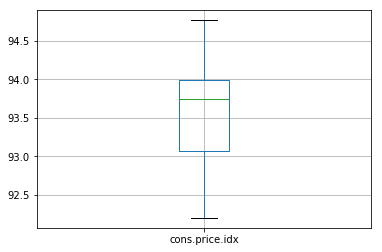

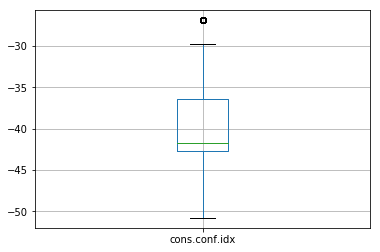

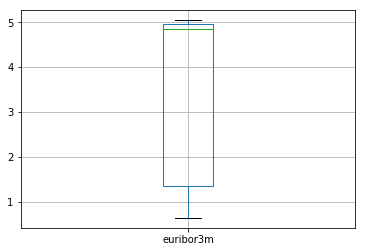

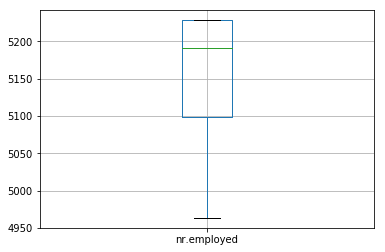

In [28]:
for ft in numeric_features.columns:
  plt.figure();
  numeric_features[[ft]].boxplot();

In [22]:
numeric_features.describe()

,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000
mean,40.048983,2.567648,0.173080,0.079347,93.573330,-40.497939,3.618948,5166.964003
std,10.447702,2.778174,0.497709,1.571305,0.579098,4.636680,1.734956,72.220794
min,17.000000,1.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,1.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,2.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,3.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,56.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


### Apply transformations

### Run the algorithms

### Compare to baseline